# MapScript Quick Start

Welcome to the Python MapScript quick start guide. 
MapScript provides a programming interface to MapServer, and this notebook
provides an overview of its key functionality. 

## Mapfiles
The simplest way to use MapScript is to work with an existing [Mapfile](https://mapserver.org/mapfile/). 
A new ```mapObj``` can be created by passing the path to a Mapfile. We will 
be working with the Itasca demo map that is also used in the 
[MapServer Demo](http://localhost/mapserver_demos/itasca/) on OSGeoLive. 

In [1]:
import sys
sys.path.append("/rofs/usr/lib/python2.7/dist-packages") # temporary hack for OSGeoLive

import os
import mapscript
from IPython.display import Image

demo_fld = os.getenv("MAPSERVER_DEMO")
mapfile = os.path.join(demo_fld, "itasca.map")

map = mapscript.mapObj(mapfile)

Anything found in the Mapfile can be accessed and manipulated using MapScript. 
For example we can get the count of all the layers in the Mapfile, and loop
through them printing out each layers name. 

MapScript objects are typically accessed using an index. 

In [2]:
for idx in range(0, map.numlayers):
    lyr = map.getLayer(idx)
    print(lyr.name)

drgs
ctybdpy2
mcd90py2
twprgpy3
lakespy2
dlgstln2
ctyrdln3
ctyrdln3_anno
majrdln3
majrdln3_anno
airports
mcd90py2_anno


## Drawing Maps
MapScript can be used to create an image file. The draw method
returns an imageObj which can be saved to a filename on disk. 

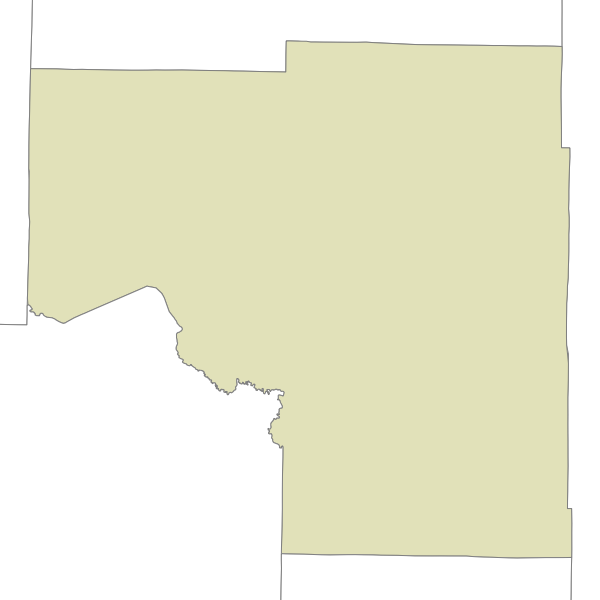

In [3]:
import tempfile
# before creating images let's set the working directory to the temp folder
os.chdir(tempfile.gettempdir()) 

output_file = "map.png"
image = map.draw()
image.save(output_file)
Image(filename=output_file)

The map image above doesn't contain all the layers in the Mapfile. 
This can be because they are set to hidden by default using ```LAYER STATUS OFF```.

To turn on these layers and create a more interesting map, we 
can loop through the layers again and set their ```STATUS``` to ```ON```. 
We can then use the ```isVisible``` method to check if the layer will
be drawn onto the map. 

In [4]:
for idx in range(0, map.numlayers):
    lyr = map.getLayer(idx)
    lyr.status = mapscript.MS_ON
    print(lyr.name, lyr.isVisible())

('drgs', 1)
('ctybdpy2', 0)
('mcd90py2', 1)
('twprgpy3', 1)
('lakespy2', 1)
('dlgstln2', 1)
('ctyrdln3', 0)
('ctyrdln3_anno', 0)
('majrdln3', 1)
('majrdln3_anno', 1)
('airports', 1)
('mcd90py2_anno', 1)


You may notice that the *ctybdpy2* layer is still not visible even though
we set its ```STATUS``` to ```ON```. This is due to the ```REQUIRES``` keyword in its layer 
definition that hides the layer if the *drgs* layer is displayed. 
The *ctyrdln3* and *ctyrdln3_anno* layers are both hidden because of the ```MAXSCALE 300000```
layer setting. 

Now we can now draw the map again with the newly visible layers. 

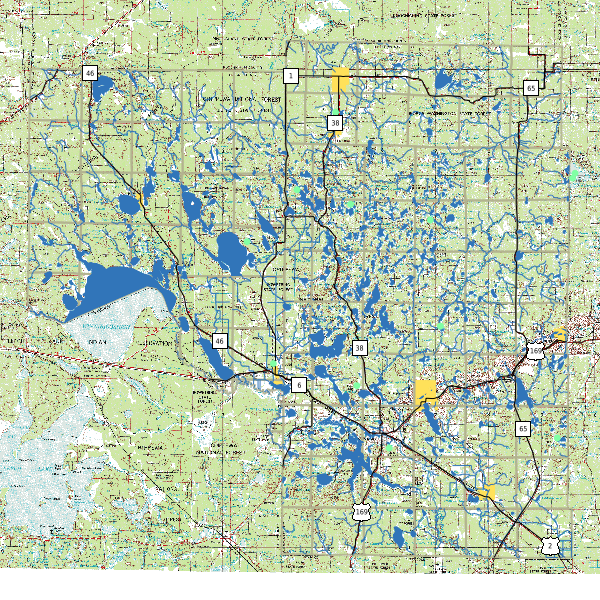

In [5]:
output_file = "map_full.png"
image = map.draw()
image.save(output_file)
Image(filename=output_file)

Other types of images can also be created from the ```mapObj```. These
use the same process of creating an ```imageObj``` and saving it to disk. 

For example to create a legend image:

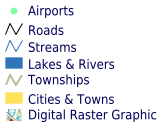

In [6]:
output_file = "map_legend.png"
legend_img = map.drawLegend()
legend_img.save(output_file)
Image(filename=output_file)

## Querying Maps
As well as drawing maps using MapScript we can also query the data
referenced by the layers. In this example we will be finding the
layer to query using its name, and then querying the ```NAME``` field to find
the name of an airport. 

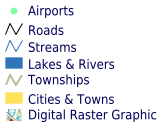

In [7]:
qry_layer = map.getLayerByName('airports')
qry_layer.queryByAttributes(qry_layer.map, "NAME", "Bowstring Municipal Airport", 
                            mapscript.MS_SINGLE)

results = qry_layer.getResults()
assert results.numresults == 1 # as we did a single query (using MS_SINGLE) there should be only one result
result = results.getResult(0)
Image(filename=output_file)

Query results are stored as ```resultCacheObj```. These contain a reference to the
result feature - a ```shapeObj```. The ```shapeObj``` can access both the geometry and 
attributes of a feature. 

Let's get the ```shapeObj``` from the ```resultCacheObj``` and 
loop through the shapes attributes to store them in a list. 

In [8]:
result_shp = qry_layer.getShape(result)

values = []
for idx in range(0, result_shp.numvalues):
    values.append(result_shp.getValue(idx))

print(values)

['Bowstring Municipal Airport', '47.5583', '-93.8689', '1372.0000', 'Jessie Lake']


It would be nice to have also the property names alongside the values. Field names
are stored in the layer in which the ```shapeObj``` belongs, and not in the ```shapeObj```
itself. We can get a list of fields from the layer, and then use the Python ```zip``` function
to join them with the shape values: 

In [9]:
fields = []
for idx in range(0, qry_layer.numitems):
    fields.append(qry_layer.getItem(idx))

print(fields)
props = zip(fields, values)  # join fields to values
print(props)

['NAME', 'LAT', 'LON', 'ELEVATION', 'QUADNAME']
[('NAME', 'Bowstring Municipal Airport'), ('LAT', '47.5583'), ('LON', '-93.8689'), ('ELEVATION', '1372.0000'), ('QUADNAME', 'Jessie Lake')]


We can also create a map showing the query results: 
*Note the imageObj is broken for Python MapScript 7.0, but is fixed in 7.2*

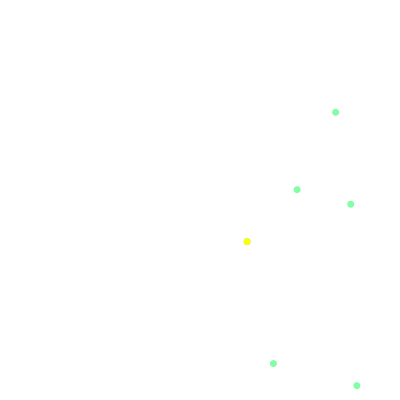

In [10]:
# create a new 400 by 400 empty image
query_image = mapscript.imageObj(400, 400)
# draw the query into the image and save it to file
qry_layer.drawQuery(qry_layer.map, query_image)
output_file = r"layer_query.png"
query_image.save(output_file)
Image(filename=output_file)

If we want to zoom in on the results we can set the map extent to a buffered area
around the results: 

(434634.0, 5267578.0, 434634.0, 5267578.0)


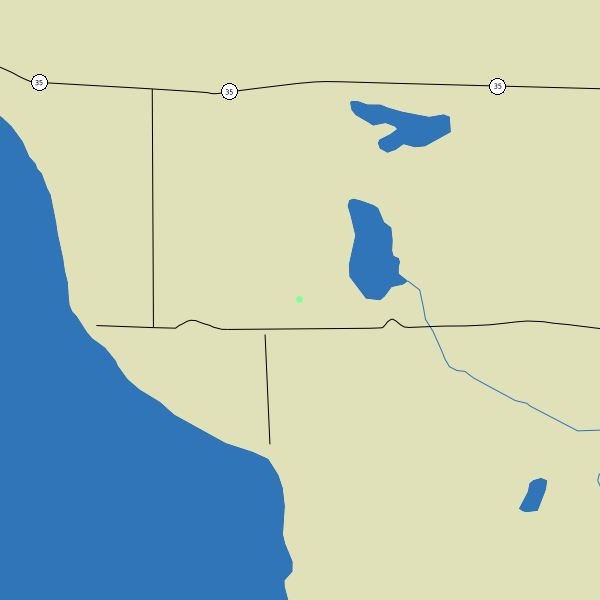

In [11]:
bbox = result_shp.bounds
print(bbox.minx, bbox.miny, bbox.maxx, bbox.maxy)
buffer = 2000

map.getLayerByName('drgs').status = mapscript.MS_OFF # hide the raster layer for this map
map.setExtent(bbox.minx - buffer, bbox.miny - buffer, bbox.maxx + buffer, bbox.maxy + buffer)

output_file = r"map_query.png"
image = map.draw()
image.save(output_file)
Image(filename=output_file)

## OGC Web Services

MapScript can also be used to send requests to MapServer OWS capabilities, to 
query WMS and WFS services. First we will get the WMS GetCapabilities XML for the map: 

In [12]:
ows_req = mapscript.OWSRequest()
ows_req.type = mapscript.MS_GET_REQUEST
ows_req.setParameter("SERVICE", "WMS");
ows_req.setParameter("VERSION", "1.3.0");
ows_req.setParameter("REQUEST", "GetCapabilities");

We use the msIO methods to capture the response the request
that is sent to ```stdout```. 
The response is typically an HTTP response with HTTP content headers. 
We can strip these out using MapScript

In [13]:
mapscript.msIO_installStdoutToBuffer()
map.OWSDispatch(ows_req)
content_type = mapscript.msIO_stripStdoutBufferContentType()
# remove the content type header from the XML
mapscript.msIO_stripStdoutBufferContentHeaders() # Strip all Content-* headers
result = mapscript.msIO_getStdoutBufferBytes()
print(result)

<?xml version='1.0' encoding="UTF-8" standalone="no" ?>
<WMS_Capabilities version="1.3.0"  xmlns="http://www.opengis.net/wms"   xmlns:sld="http://www.opengis.net/sld"   xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"   xmlns:ms="http://mapserver.gis.umn.edu/mapserver"   xsi:schemaLocation="http://www.opengis.net/wms http://schemas.opengis.net/wms/1.3.0/capabilities_1_3_0.xsd  http://www.opengis.net/sld http://schemas.opengis.net/sld/1.1.0/sld_capabilities.xsd  http://mapserver.gis.umn.edu/mapserver http://localhost.localdomain/mapserver_demos/itasca/index.html?service=WMS&amp;version=1.3.0&amp;request=GetSchemaExtension">

<!-- MapServer version 7.2.1 OUTPUT=PNG OUTPUT=JPEG OUTPUT=KML SUPPORTS=PROJ SUPPORTS=AGG SUPPORTS=FREETYPE SUPPORTS=CAIRO SUPPORTS=SVG_SYMBOLS SUPPORTS=SVGCAIRO SUPPORTS=ICONV SUPPORTS=FRIBIDI SUPPORTS=WMS_SERVER SUPPORTS=WMS_CLIENT SUPPORTS=WFS_SERVER SUPPORTS=WFS_CLIENT SUPPORTS=WCS_SERVER SUPPORTS=SOS_SERVER SUPPORTS=FASTCGI SUPPORTS=THREADS SUPPORTS=GEOS S

We can also retrieve images from a WMS service. 
Rather than setting lots of individual parameters we can simply load them from
a string in the same format was would be sent via a web client. 

{ 'minx': 432634 , 'miny': 5265578 , 'maxx': 436634 , 'maxy': 5269578 }


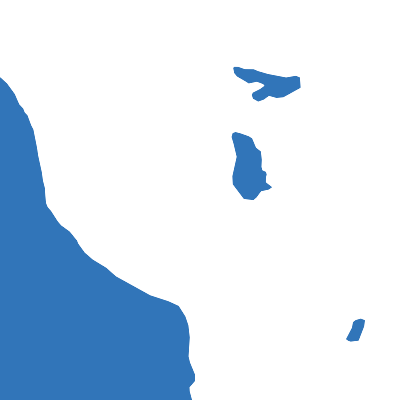

In [14]:
# First let's get the extent of the map to use in the request
extent = map.extent
print(extent)

bbox = "BBOX={},{},{},{}".format(extent.minx, extent.miny, extent.maxx, extent.maxy)
querystring = "SERVICE=WMS&REQUEST=GetMap&VERSION=1.3.0&LAYERS=lakespy2&CRS=EPSG:26915&FORMAT=image/png&WIDTH=400&HEIGHT=400&{}".format(bbox)

ows_req = mapscript.OWSRequest()
ows_req.loadParamsFromURL(querystring)
success = map.OWSDispatch(ows_req)
assert success == mapscript.MS_SUCCESS

# clear the HTTP headers or we will have an invalid image
headers = mapscript.msIO_getAndStripStdoutBufferMimeHeaders()
result = mapscript.msIO_getStdoutBufferBytes()

output_file = "wms.png"
with open(output_file, "wb") as f:
    f.write(result)

Image(filename=output_file)

Finally let's get the SLD for one of the layers in the map: 

In [15]:
lakes_layer = map.getLayerByName('lakespy2')
result = lakes_layer.generateSLD()
print(result)

<StyledLayerDescriptor version="1.0.0" xmlns="http://www.opengis.net/sld" xmlns:gml="http://www.opengis.net/gml" xmlns:ogc="http://www.opengis.net/ogc" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.opengis.net/sld http://schemas.opengis.net/sld/1.0.0/StyledLayerDescriptor.xsd">
<NamedLayer>
<Name>lakespy2</Name>
<UserStyle>
<FeatureTypeStyle>
<Rule>
<Name>Lakes &amp; Rivers</Name>
<MinScaleDenominator>1000.000000</MinScaleDenominator>
<MaxScaleDenominator>1550000.000000</MaxScaleDenominator>
<PolygonSymbolizer>
<Fill>
<CssParameter name="fill">#3175b9</CssParameter>
</Fill>
</PolygonSymbolizer>
</Rule>
</FeatureTypeStyle>
</UserStyle>
</NamedLayer>
</StyledLayerDescriptor>



Thanks for working through this notebook! For more information on MapScript
please see the [MapScript documentation](https://mapserver.org/mapscript/introduction.html). 
Additional Python examples can be found in the [MapServer GitHub repository](https://github.com/mapserver/mapserver/tree/master/mapscript/python/examples)